In [ ]:
# =====================================================
# 📦 1. Imports
# =====================================================
import pandas as pd
import numpy as np
import joblib
import json
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import load_model
from xgboost import XGBClassifier


In [ ]:

# =====================================================
# 📥 2. Load Models, Scalers, and Metadata
# =====================================================
# Paths
base_path = "/content/drive/MyDrive/Hackathon Models/3. Bone Density and Microgravity Effects/"

# Load models
xgb_model = joblib.load(base_path + "xgb_model.pkl")
nn_model = load_model(base_path + "osteoporosis_risk_nn_model_shap.h5")

# Load scalers
scaler_xgb = joblib.load(base_path + "scaler_xgb.pkl")
scaler_nn = joblib.load(base_path + "scaler_shap.pkl")

# Load metadata
with open(base_path + "model_metadata.json") as f:
    meta_xgb = json.load(f)
with open(base_path + "model_metadata_shap.json") as f:
    meta_nn = json.load(f)

# Load feature sets
features_xgb = meta_xgb['features']
features_nn = meta_nn['features']
threshold_xgb = meta_xgb['optimal_threshold']
threshold_nn = meta_nn['optimal_threshold']


In [ ]:
# =====================================================
# 🧪 3. Load and Prepare Test Data
# =====================================================
df = pd.read_csv("/content/bone density and microgravity.csv")
df.dropna(subset=['htotbmd', 'bmd25', 'rtgroup'], inplace=True)

# Recalculate engineered features
df['age_weight_ratio'] = df['ra_age'] / df['p3_weigh']
df['interaction'] = df['ra_age'] * df['trialyrs']

# Targets
y_true = df['bmd25'].values

# Separate feature matrices
X_xgb = df[features_xgb]
X_nn = df[features_nn]

# Apply corresponding scalers
X_xgb_scaled = scaler_xgb.transform(X_xgb)
X_nn_scaled = scaler_nn.transform(X_nn)


In [ ]:
# =====================================================
# 🤝 4. Ensemble Prediction (Soft Voting)
# =====================================================
# Predict probabilities
proba_xgb = xgb_model.predict_proba(X_xgb_scaled)[:, 1]
proba_nn = nn_model.predict(X_nn_scaled).flatten()

# Soft vote
ensemble_proba = (proba_xgb + proba_nn) / 2

# Average threshold
avg_thresh = (threshold_xgb + threshold_nn) / 2
print("📌 Ensemble Threshold:", round(avg_thresh, 4))

# Final prediction
ensemble_pred = (ensemble_proba >= avg_thresh).astype(int)


199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📌 Ensemble Threshold: 0.3417


🎯 Ensemble ROC AUC: 0.8849
✅ Ensemble Accuracy: 75.15 %
🧪 Ensemble Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.68      0.79      4312
         1.0       0.57      0.91      0.70      2054

    accuracy                           0.75      6366
   macro avg       0.76      0.79      0.74      6366
weighted avg       0.82      0.75      0.76      6366



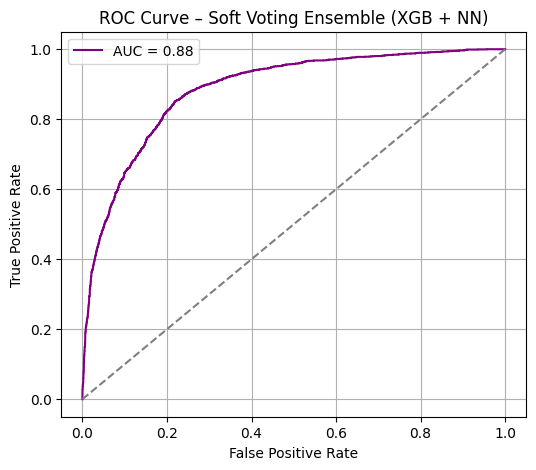

In [ ]:
# =====================================================
# 📈 5. Evaluation
# =====================================================
roc_auc = roc_auc_score(y_true, ensemble_proba)
acc = accuracy_score(y_true, ensemble_pred)
report = classification_report(y_true, ensemble_pred)

print("🎯 Ensemble ROC AUC:", round(roc_auc, 4))
print("✅ Ensemble Accuracy:", round(acc * 100, 2), "%")
print("🧪 Ensemble Classification Report:\n", report)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, ensemble_proba)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Soft Voting Ensemble (XGB + NN)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# =====================================================
# 💾 6. Wrap as a Single Model and Save
# =====================================================
class BoneDensityEnsembleModel:
    def __init__(self, xgb_model, nn_model, scaler_xgb, scaler_nn,
                 features_xgb, features_nn, threshold):
        self.xgb_model = xgb_model
        self.nn_model = nn_model
        self.scaler_xgb = scaler_xgb
        self.scaler_nn = scaler_nn
        self.features_xgb = features_xgb
        self.features_nn = features_nn
        self.threshold = threshold

    def engineer_features(self, df):
        df = df.copy()
        df['age_weight_ratio'] = df['ra_age'] / df['p3_weigh']
        df['interaction'] = df['ra_age'] * df['trialyrs']
        return df

    def predict(self, df):
        df = self.engineer_features(df)
        X_xgb = df[self.features_xgb]
        X_nn = df[self.features_nn]
        X_xgb_scaled = self.scaler_xgb.transform(X_xgb)
        X_nn_scaled = self.scaler_nn.transform(X_nn)

        proba_xgb = self.xgb_model.predict_proba(X_xgb_scaled)[:, 1]
        proba_nn = self.nn_model.predict(X_nn_scaled).flatten()

        ensemble_proba = (proba_xgb + proba_nn) / 2
        final_pred = (ensemble_proba >= self.threshold).astype(int)
        return final_pred, ensemble_proba


In [ ]:
# Create the ensemble model object
ensemble_model = BoneDensityEnsembleModel(
    xgb_model=xgb_model,
    nn_model=nn_model,
    scaler_xgb=scaler_xgb,
    scaler_nn=scaler_nn,
    features_xgb=features_xgb,
    features_nn=features_nn,
    threshold=avg_thresh
)

# Save it
joblib.dump(ensemble_model, base_path + "bone_density_ensemble_model.pkl")
print("✅ Ensemble model saved as ONE unified model 🎉")

✅ Ensemble model saved as ONE unified model 🎉


In [ ]:
import pandas as pd

sample_data = pd.DataFrame([{
    "ra_age": 45,              # Age of astronaut
    "p3_weigh": 70,            # Weight in kg
    "trialyrs": 1.2,           # Simulated years in microgravity
    "trt01": 1,                # Treatment group (e.g. 1 = treated)
    "rtgroup": "Drug A"        # Encoded treatment type (must match original label encoder)
}])

In [ ]:
sample_data["age_weight_ratio"] = sample_data["ra_age"] / sample_data["p3_weigh"]
sample_data["interaction"] = sample_data["ra_age"] * sample_data["trialyrs"]


In [ ]:
# Load your final saved model
import joblib
model = joblib.load("/content/drive/MyDrive/Hackathon Models/3. Bone Density and Microgravity Effects/bone_density_ensemble_model.pkl")

# Run prediction
pred, proba = model.predict(sample_data)

print("🧠 Predicted Risk Class:", pred[0])  # 0 = Low Risk, 1 = High Risk
print("📊 Risk Probability:", round(proba[0], 4))


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
🧠 Predicted Risk Class: 0
📊 Risk Probability: 0.2883
